In [1]:
!pip install vnstock

# Import Lib

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from math import log2
from scipy.special import rel_entr
from operator import itemgetter
from vnstock import *

import cufflinks as cf
cf.go_offline()
import plotly.io as pio 
pio.renderers.default = "colab"

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn import metrics

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



# EDA

In [3]:
#List of stocks on the market
df = listing_companies()
print("Shape:", df.shape)
print(df.head())
#Randomly select 20 stock codes for analysis
a = df.sample(n=20)
lst = a['ticker']

    

Shape: (1631, 4)
  ticker  group_code                                    company_name  \
0    VVS  UpcomIndex  Công ty Cổ phần Đầu tư Phát triển Máy Việt Nam   
1    XDC  UpcomIndex   Công ty TNHH MTV Xây dựng Công trình Tân Cảng   
2    HSV  UpcomIndex                Công ty Cổ phần Gang Thép Hà Nội   
3    CST  UpcomIndex              Công ty Cổ phần Than Cao Sơn - TKV   
4    BVL  UpcomIndex                         Công ty Cổ phần BV Land   

               company_short_name  
0  Đầu tư Phát triển Máy Việt Nam  
1    Xây dựng Công trình Tân Cảng  
2                Gang Thép Hà Nội  
3              Than Cao Sơn - TKV  
4                         BV Land  


In [4]:
# Retrieve historical price data of any n stocks
start = "2018-01-01"
end  = dt.datetime.now().strftime("%Y-%m-%d")
empt_lists = []
for i in tqdm(lst):
    empt_lists.append(i)
    globals()[i] =  stock_historical_data(symbol=i, start_date=start, end_date=end).set_index('TradingDate')
#Convert list to globals
empt_lists_new = empt_lists
empt_lists_new = globals()

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


In [5]:
bank_stocks = pd.concat(empt_lists_new, axis = 1, keys = empt_lists)
print(bank_stocks.head())
value_banks = pd.DataFrame()
for name in empt_lists:
    value_banks[name] = bank_stocks[name]['Close']
value_banks.dropna(inplace= True)
#Get weekly data
value_banks = value_banks.resample('W').last()
#Calculate rate of return (% change over time)
stoc_returns = value_banks.pct_change().fillna(method='bfill')#pct_change(): (current row value – previous row value)/ (previous row value).
stoc_returns.head()
def get_name(symbol):
    return df['company_short_name'][df['ticker']==symbol].values
    
def plot_stock(symbol, stocks=value_banks):
    stocks[symbol].plot(title=symbol, label=symbol, alpha=0.9);

                SDJ                                     TMS                    \
               Open    High     Low   Close Volume     Open     High      Low   
TradingDate                                                                     
2018-01-02   8000.0  8000.0  6100.0  7500.0    800  18541.0  19783.0  18541.0   
2018-01-03   7500.0  7500.0  7500.0  7500.0      0  18863.0  19484.0  18863.0   
2018-01-04   7500.0  7500.0  7500.0  7500.0      0  19655.0  19655.0  18970.0   
2018-01-05   8600.0  8600.0  8600.0  8600.0    100  18970.0  19676.0  18970.0   
2018-01-08   9500.0  9500.0  9500.0  9500.0    100  19269.0  19484.0  18948.0   

                             ...     VNE                                   \
               Close Volume  ...    Open    High     Low   Close   Volume   
TradingDate                  ...                                            
2018-01-02   18863.0   3370  ...  7005.0  7005.0  6848.0  6895.0   242290   
2018-01-03   19376.0   3290  ...  6922.0  7

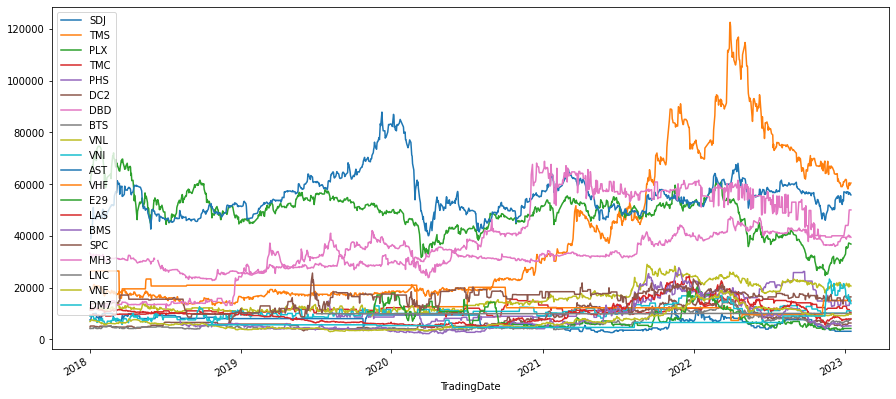

In [6]:
for tick in empt_lists:
    bank_stocks[tick]['Close'].plot(figsize=(15,7),label=tick)
plt.legend()

## Principal Components Analysis and Clustering

In [7]:
pca = PCA(n_components=.95, random_state=1)
components = pca.fit_transform(stoc_returns.T)
print('Number of PCA components', components.shape[1])
print('PCA explained variance ratio:', pca.explained_variance_ratio_)
print('PCA total explained variance: ', np.sum(pca.explained_variance_ratio_))

Number of PCA components 14
PCA explained variance ratio: [0.2055222  0.14953506 0.11003813 0.08860719 0.07209498 0.05526277
 0.05028855 0.04824579 0.03784179 0.0354721  0.029418   0.0259589
 0.02308014 0.02207806]
PCA total explained variance:  0.9534436533884213


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.



Number of dimensions for clustering with PCA:  14


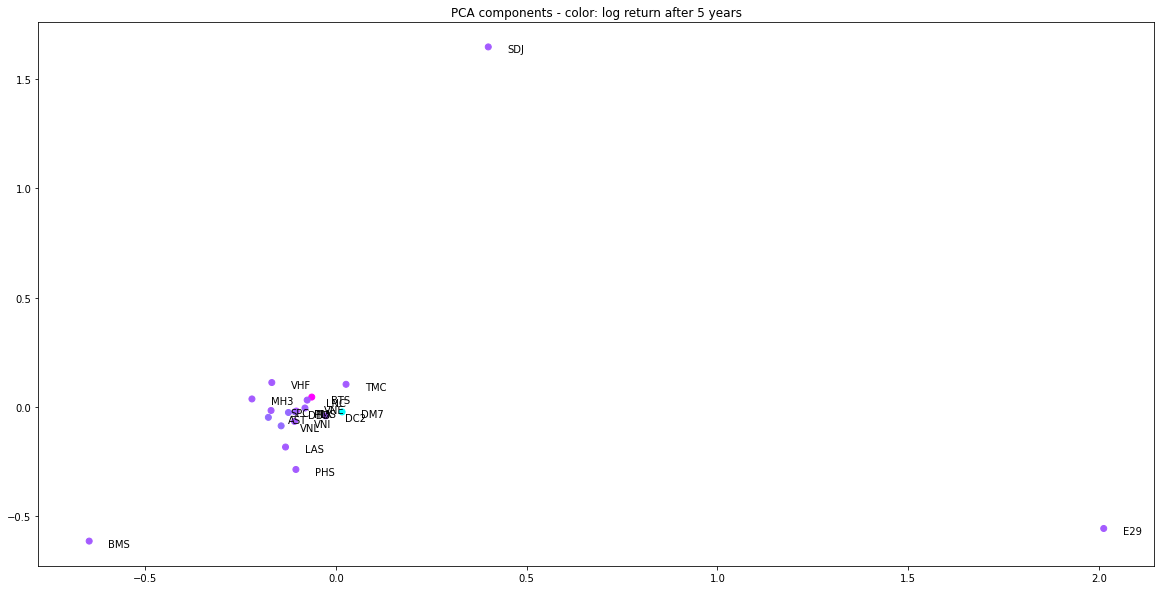

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1],  c = stoc_returns.iloc[-1].T.apply(np.log1p), cmap='cool')
for i in range(components.shape[0]): 
    plt.text(x=components[i,0]+0.05, y=components[i,1]-0.025, s=stoc_returns.columns[i])
plt.title('PCA components - color: log return after 5 years')
print('Number of dimensions for clustering with PCA: ', len(components.T))

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(components);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(components)):
    clusters[l].append(value_banks.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end='; ')
    print()
    print()

Cluster 0: ['Transimex (TMS)']; ['Petrolimex (PLX)']; ['XNK Thủ Đức (TMC)']; ['Chứng khoán Phú Hưng (PHS)']; ['DIC Số 2 (DC2)']; ['Dược - TB Y tế Bình Định (DBD)']; ['Xi măng Bút Sơn (BTS)']; ['Logistics Vinalink (VNL)']; ['ĐT BĐS Việt Nam (VNI)']; ['Dịch vụ Hàng không Taseco (AST)']; ['Chế biến lương thực Vĩnh Hà (VHF)']; ['Hóa chất Lâm Thao (LAS)']; ['Chứng khoán Bảo Minh (BMS)']; ['BV Thực vật Sài Gòn (SPC)']; ['KCN Cao su Bình Long (MH3)']; ['Lệ Ninh - Quảng Bình (LNC)']; ['Xây dựng điện Việt Nam (VNE)']; ['Dệt may 7 (DM7)']; 

Cluster 1: ['Đầu tư XD và Kỹ thuật 29 (E29)']; 

Cluster 2: ['Sông Đà 25 (SDJ)']; 



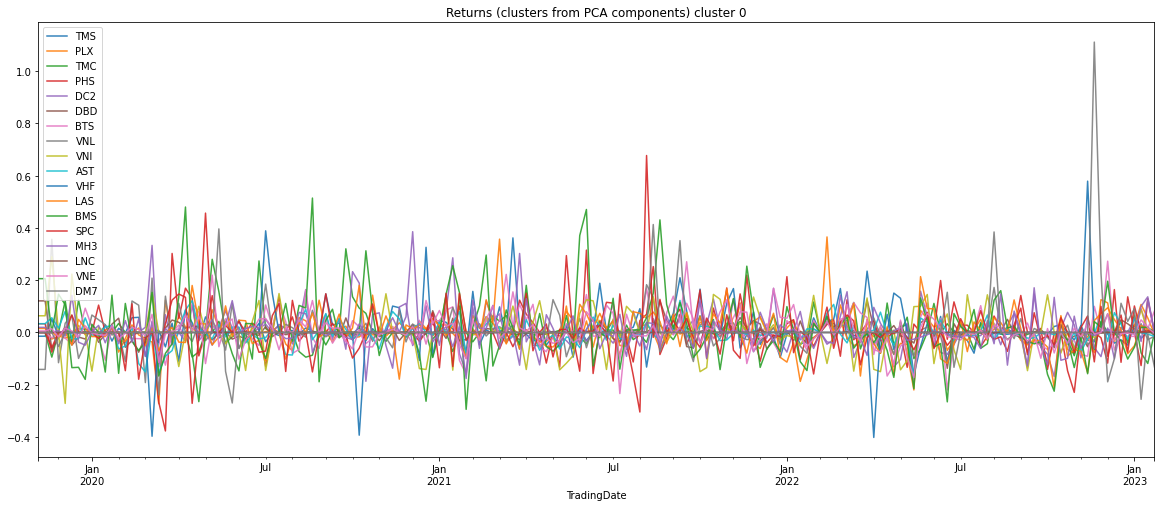

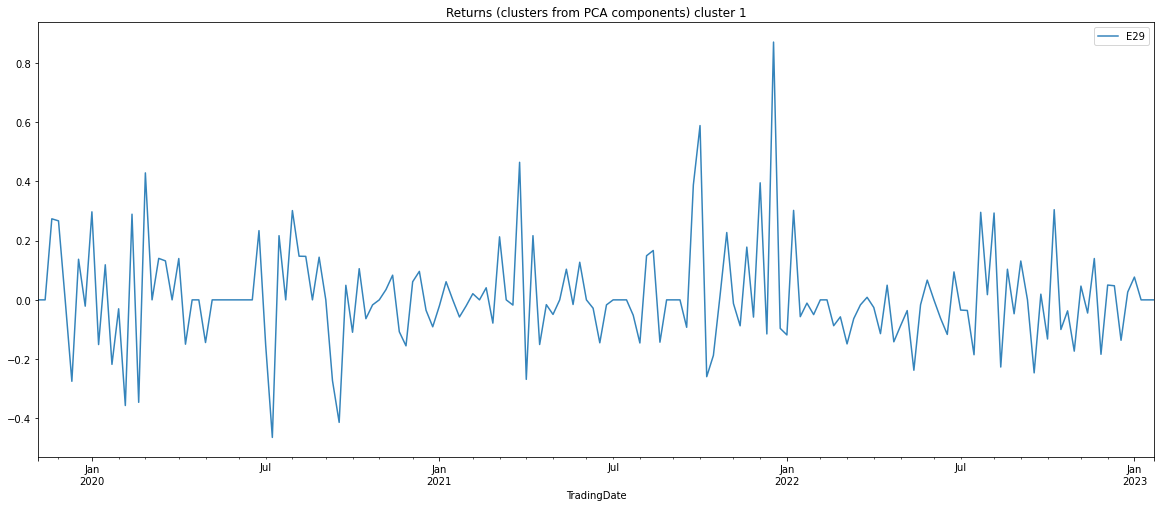

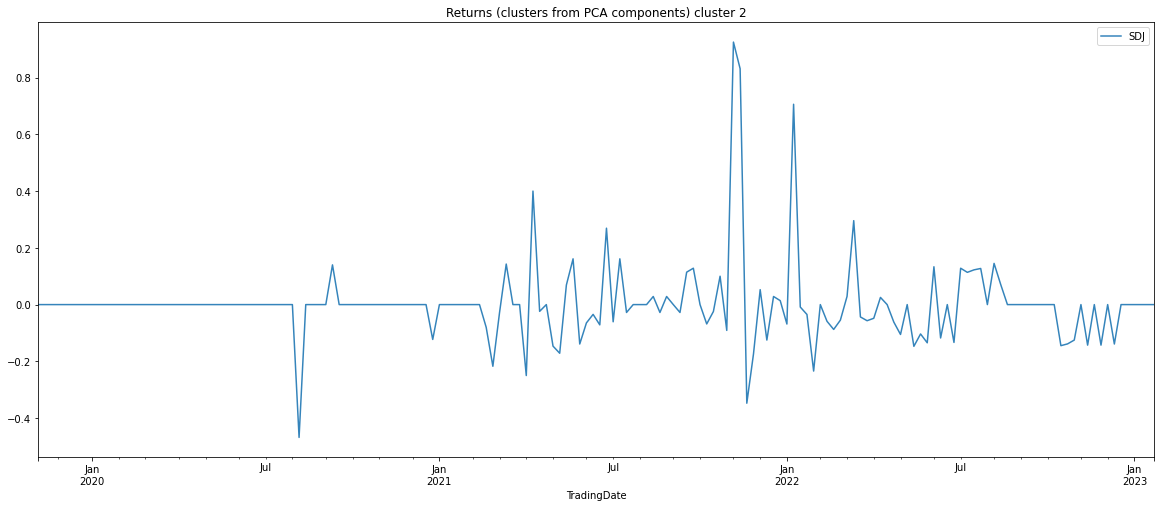

In [10]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=stoc_returns)
    plt.title('Returns (clusters from PCA components) cluster ' + str(c))
    plt.legend()
    plt.show()

## Gaussian Mixture model

In [11]:
#Lấy các mã cổ phiếu của VNINDEX group
lst_vnindex = df['ticker'][df['group_code']=='VNINDEX']
lst_vnindex.unique()

array(['FUCTVGF3', 'FUEIP100', 'GMH', 'FUEKIV30', 'NO1', 'FUCTVGF4',
       'FUEDCMID', 'FUEKIVFS', 'AAA', 'AAM', 'AAT', 'ABR', 'ABS', 'ABT',
       'ACB', 'ACC', 'ACL', 'AGM', 'AGR', 'AGG', 'AMD', 'ACG', 'ANV',
       'APC', 'APG', 'APH', 'HII', 'ASG', 'ASM', 'ASP', 'BAF', 'BBC',
       'BCE', 'BCG', 'BFC', 'BHN', 'BIC', 'BID', 'BCM', 'DBD', 'BWE',
       'BKG', 'BMC', 'BMI', 'BMP', 'BRC', 'BSI', 'BTP', 'BTT', 'BVH',
       'TNH', 'C32', 'C47', 'CAV', 'CCI', 'CCL', 'CDC', 'CRE', 'STK',
       'CHP', 'CIG', 'CII', 'CKG', 'CLC', 'ADG', 'CLL', 'CLW', 'CMG',
       'CMV', 'CMX', 'CNG', 'COM', 'CRC', 'CSM', 'CSV', 'CTD', 'CTF',
       'CTG', 'CTI', 'ICT', 'CTR', 'CTS', 'CVT', 'D2D', 'DAG', 'DAH',
       'ADS', 'DPG', 'DBC', 'DBT', 'DC4', 'DCL', 'DCM', 'DGC', 'DGW',
       'DHA', 'DHC', 'DHG', 'DHM', 'TTE', 'DIG', 'DLG', 'DMC', 'DPM',
       'DPR', 'DQC', 'DRC', 'DRH', 'DRL', 'DSN', 'DTA', 'DTL', 'DTT',
       'DVP', 'DXG', 'DXS', 'DXV', 'FUESSV50', 'E1VFVN30', 'EIB', 'ELC',
       'EMC', '

In [12]:
start = "2017-01-01"
end  = dt.datetime.now().strftime("%Y-%m-%d")
empt_lists_b = []
for i in tqdm(lst_vnindex):
    empt_lists_b.append(i)
    globals()[i] =  stock_historical_data(symbol=i, start_date=start, end_date=end).set_index('TradingDate')
    
empt_lists_new_b = empt_lists_b
empt_lists_new_b = globals()
bank_stocks_b = pd.concat(empt_lists_new_b, axis = 1, keys = empt_lists_b)
bank_stocks_b.tail()

100%|██████████| 417/417 [14:06<00:00,  2.03s/it]


FUCTVGF3                                   FUEIP100          \
                Open     High      Low    Close Volume     Open    High   
TradingDate                                                               
2023-01-10   16800.0  16800.0  16800.0  16800.0    0.0   7470.0  7540.0   
2023-01-11   16800.0  16800.0  16800.0  16800.0    0.0   7500.0  7620.0   
2023-01-12   16800.0  16800.0  16800.0  16800.0    0.0   7510.0  7540.0   
2023-01-13   16800.0  16800.0  16800.0  16800.0    0.0   7000.0  7600.0   
2023-01-16       NaN      NaN      NaN      NaN    NaN   8010.0  8010.0   

                                      ...     YBM                          \
                Low   Close   Volume  ...    Open    High     Low   Close   
TradingDate                           ...                                   
2023-01-10   7470.0  7520.0  48600.0  ...  5780.0  5780.0  5700.0  5710.0   
2023-01-11   7500.0  7550.0  41500.0  ...  5710.0  5730.0  5320.0  5720.0   
2023-01-12   7480.0  7480.0  47300.0  ...  5710.0  5710.0  5690.0  5690.0   
2023-01-13   7000.0  7490.0  45200.0  ...  5700.0  5700.0  5500.0  5500.0   
2023-01-16   7510.0  7530.0  48400.0  ...  5690.0  5720.0  5500.0  5500.0   

                         YEG                                   
              Volume    Open    High     Low   Close   Volume  
TradingDate                                                    
2023-01-10    7701.0  8750.0  8840.0  8450.0  8620.0  63612.0  
2023-01-11   12500.0  8630.0  8920.0  8600.0  8600.0  84800.0  
2023-01-12    2400.0  8600.0  8780.0  8410.0  8700.0  51900.0  
2023-01-13   21300.0  8520.0  8800.0  8520.0  8640.0  33900.0  
2023-01-16   63100.0  8520.0  8840.0  8400.0  8440.0  44600.0  

[5 rows x 2085 columns]

In [13]:
value_banks_b = pd.DataFrame()
for name in empt_lists_b:
    value_banks_b[name] = bank_stocks_b[name]['Close']
value_banks_b.dropna(inplace= True)

#Calculate profit margin
vnindex_returns_b = value_banks_b.pct_change().fillna(method='bfill')
vnindex_returns_b.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



,FUCTVGF3,FUEIP100,GMH,FUEKIV30,NO1,FUCTVGF4,FUEDCMID,FUEKIVFS,AAA,AAM,...,VPI,VRC,VRE,VSC,VSH,VSI,VTB,VTO,YBM,YEG
TradingDate,,,,,,,,,,,,,,,,,,,,,
2022-11-28,0.0,0.018545,-0.007092,0.003072,-0.047847,0.017382,0.042216,0.005063,0.000000,0.000000,...,0.012069,0.030683,0.040956,-0.003106,0.022581,0.061810,-0.008403,0.000000,0.017889,0.005488
2022-11-29,0.0,0.018545,-0.007092,0.003072,-0.047847,0.017382,0.042216,0.005063,0.000000,0.000000,...,0.012069,0.030683,0.040956,-0.003106,0.022581,0.061810,-0.008403,0.000000,0.017889,0.005488
2022-11-30,0.0,0.015406,-0.007143,0.062787,-0.045226,-0.069347,0.012658,0.036524,0.020270,0.049774,...,0.039182,-0.037889,0.001639,-0.017134,-0.006309,0.000000,0.008475,0.001342,0.001757,-0.013100
2022-12-01,0.0,0.001379,-0.014388,-0.017291,-0.052632,-0.069114,0.005000,0.003645,0.006623,0.000000,...,-0.001639,0.054852,-0.018003,0.012678,-0.006349,-0.047598,-0.008403,0.005362,0.049123,0.069690
2022-12-02,0.0,0.038567,-0.003650,0.043988,0.000000,-0.069606,0.044776,0.056901,0.036842,0.038793,...,-0.014778,-0.001333,0.051667,0.003130,0.000000,0.000000,0.000000,0.006667,-0.013378,0.065150


In [14]:
scaler = StandardScaler();
scaled_df = scaler.fit_transform(vnindex_returns_b.T);
normalized_df = normalize(scaled_df);
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head(2)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.



,P1,P2
0,0.514731,-0.066341
1,-0.376769,0.554000


In [15]:
gmm = GaussianMixture(n_components = 3) 
gmm.fit(X_principal)

GaussianMixture(n_components=3)

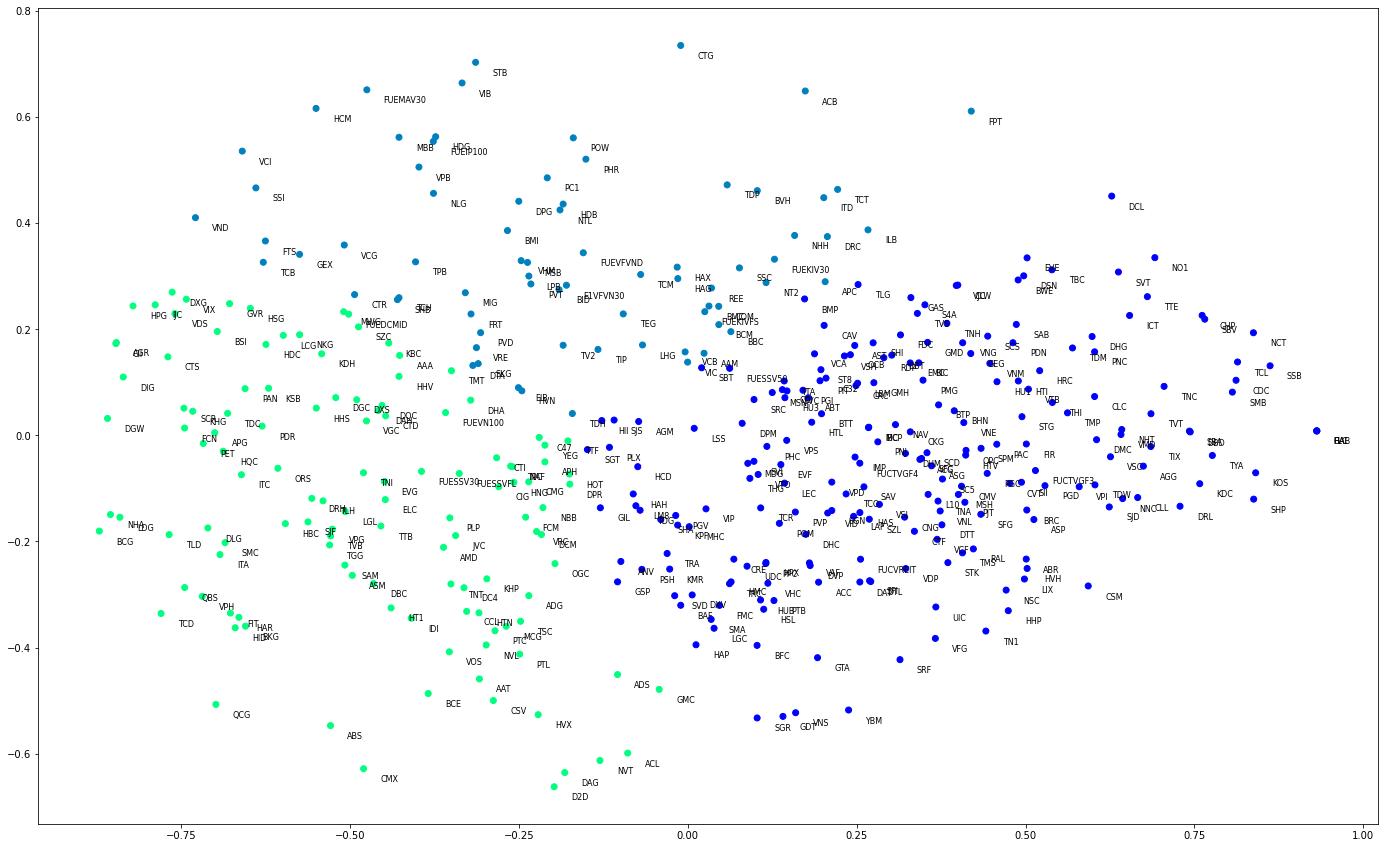

In [16]:
plt.figure(figsize=(24,15))
plt.scatter(X_principal['P1'], X_principal['P2'],  
            c = GaussianMixture(n_components = 3).fit_predict(X_principal), alpha = 1, cmap='winter') 
for i in range(X_principal.shape[0]):
  plt.text(x=X_principal['P1'][i]+0.025, y=X_principal['P2'][i]-0.025, s=vnindex_returns_b.columns[i], fontsize=8)
plt.show() 

## KullBack Leibler finds approximate VNINDEX catalog

**Idea**: Considering the data is the securities of VNINDEX group. Assuming the value of each column is a probability distribution, according to KL, the 2 probability distributions are almost the same when the value of KL gradually reaches 0. So calculate the corresponding KL for each column, K columns with the smallest value is K proof. stock can approximate VNINDEX

In [17]:
#Convert to probability value ([0,1])  
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

vnindex_returns_b = softmax(vnindex_returns_b)

In [18]:
list_sum, idx = [], []
for i in vnindex_returns_b.columns:
    tong = 0
    for j in vnindex_returns_b.columns:
        kl_pq = sum(rel_entr(list(vnindex_returns_b[i].values), list(vnindex_returns_b[j].values)))
        tong += kl_pq
    idx.append(i)
    list_sum.append(tong)
dic_KL = dict(zip(idx, list_sum))
#K shares are approximately VNINDEX
K=2
dict(sorted(dic_KL.items(), key = itemgetter(1))[:K])

{'FUEIP100': 0.1790606931695471, 'E1VFVN30': 0.18512822953816224}